# Municipality Analysis

In [178]:
#Cargando librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import reverse_geocoder as rg 
import pprint 

In [179]:
df = pd.read_csv('nutritive.csv', index_col=False)
df = df.reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0'])

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [180]:
df.shape

(937785, 25)

## Some Metadata
### l6 .... l1 : Administrative Level
### surface_total: Total surface in m2
### surface_covered : Total surface covered in m2
### bathrooms
### bedrooms
### lat
### lon

## Utility Functions

In [181]:
#import os
#os.getcwd()
#from utils.utils import relocate
#from [dir].[file.py] import relocate
#from .utils imprt relocate

In [182]:
def reverseGeocode(coordinates): 
    result = rg.search(coordinates) 
    
    return result[0]['admin1'], result[0]['name']

# Dataframe must have been given reset_indexed
# Complete missing values where deparment and municipality are unknown
def relocate(df_geo):
    n = df_geo.shape[0]
    for i in tqdm(range(0,n)):
        lat = df_geo.loc[i, 'lat']
        lon = df_geo.loc[i, 'lon']
        l2 = df_geo.loc[i, 'l2']
        l3 = df_geo.loc[i, 'l3']
        if (~np.isnan(lat) and ~np.isnan(lon)) and (pd.isnull(l3) or pd.isnull(l2)):
            df_geo.loc[i, 'l2'], df_geo.loc[i, 'l3'] = reverseGeocode((lat,lon))
            
    return df_geo

#Calculates missing data and shows dataframe
def calculate_missing(df):
    s_types = df.dtypes
    missing = df.isnull().sum()
    missing_per = (df.isnull().sum()/df.shape[0])*100

    explo = pd.DataFrame({'Type' : s_types, 'Missing' : missing,
                       'Missing%' : missing_per}).sort_values(by=['Missing%', 'Type'], ascending=False)

    return explo

#Graph missing data given dataframe
def graph_missing(df):

    df_missing = calculate_missing(df)

    df_missing = df_missing.where(df_missing['Missing%'] > 25).dropna(subset=['Missing%'])

    sns.barplot(x=df_missing.index, y=df_missing['Missing%'], data=df_missing)

## Sell and Rent Counting

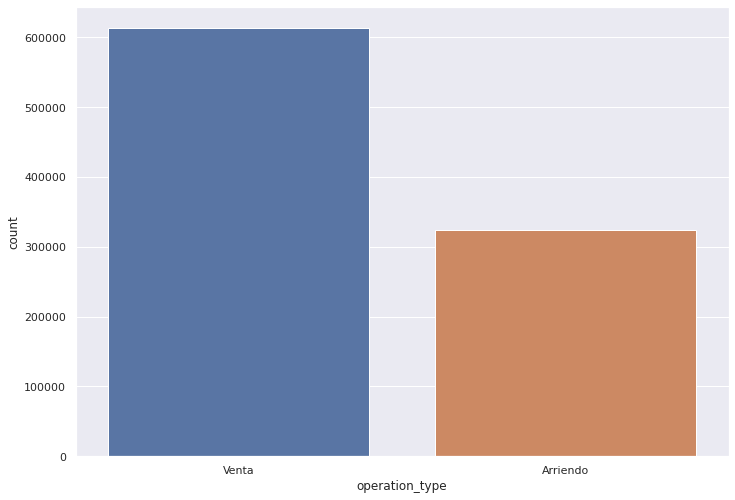

In [183]:
sns.set(rc={'figure.figsize':(11.7,8.27)})     
df = df.where(df['operation_type'] != 'Arriendo temporal')
sns.countplot(data = df, x = 'operation_type')

In [184]:
df_sell = df.where(df['operation_type'] == 'Venta').dropna(subset=['operation_type'])
df_rent = df.where(df['operation_type'] == 'Arriendo').dropna(subset=['operation_type'])

## Missing Values Graph - Sell

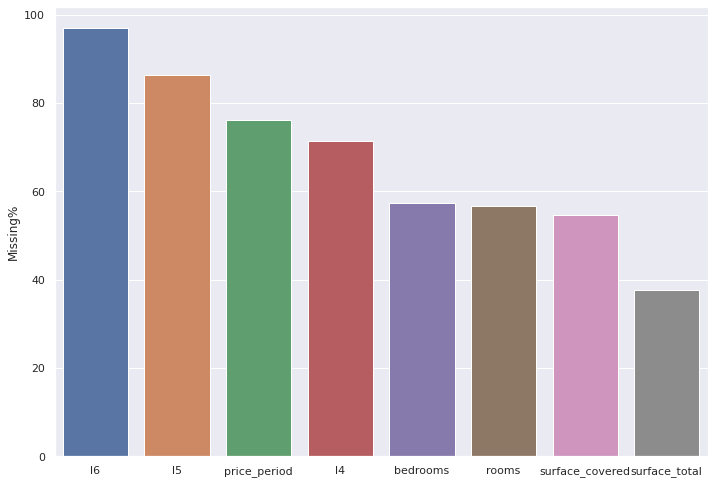

In [185]:
graph_missing(df_sell)

## Missing Values Graph - Rent

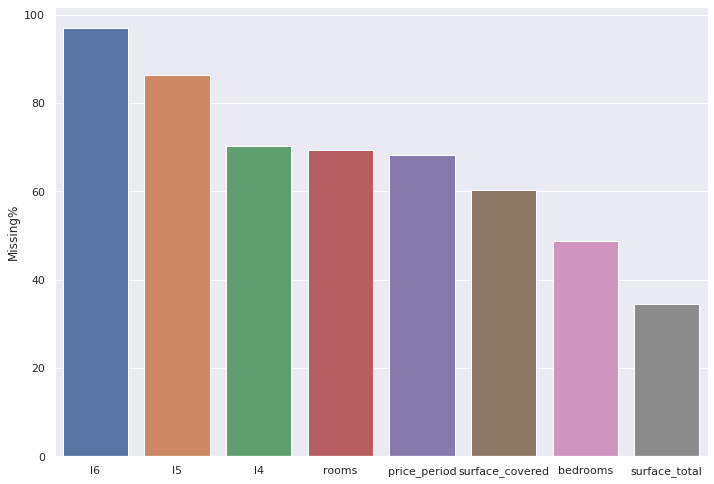

In [186]:
graph_missing(df_rent)

In [187]:
df_rent.drop(columns=['l6', 'l5', 'l4', 'rooms', 'price_period', 'surface_covered'], inplace=True)
df_sell.drop(columns=['l6', 'l5', 'l4', 'rooms', 'price_period', 'surface_covered'], inplace=True)

In [188]:
df_medellin = df_sell.where((df_sell['l3'] == 'Bogotá D.C' )| (df_sell['l3'] == 'Medellín')).dropna(subset=['l3'])

def new_features(df):
    df_features = df.copy()
    df_features = df_features[df_features["end_date"].str.contains('9999')==False]
    df_features['price_m2'] = df['price'] / df['surface_total']
    df_features['end_date'] = pd.to_datetime(df_features.end_date)
    df_features['created_on'] = pd.to_datetime(df_features.created_on)
    df_features['delta_time'] = df_features['end_date'] - df_features['created_on'] 
    df_features['delta_time'] = df_features['delta_time'].dt.days
    
    return df_features
    
df_medellin = df_medellin[df_medellin['price']<df_medellin['price'].quantile(0.98)]
df_medellin = df_medellin[df_medellin['price'] > df_medellin['price'].quantile(0.2)]
df_medellin = df_medellin[df_medellin['surface_total'] > 0]

df_medellin = new_features(df_medellin)
df_medellin['price'] = np.log(df_medellin['price'])

del df_medellin['delta_time']


df_medellin['medellin'] = df_medellin.apply(lambda x: 1 if x.l3 =='Medellín' else 0, axis=1)

#hue='species'
#sns.pairplot(df_medellin, height=2.5);

## Bogota and Medellin Logarithmic Distribution  

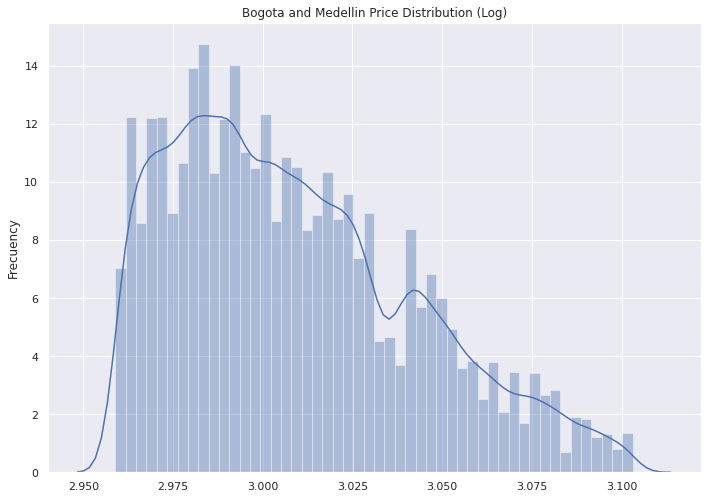

In [189]:
ax = sns.distplot(np.log(df_medellin['price']));
ax.set(xlabel='', ylabel='Frecuency',title ="Bogota and Medellin Price Distribution (Log)")
plt.show()

In [190]:
df_medellin = df_medellin.drop(columns=['id', 'ad_type', 'start_date', 'end_date', 'created_on',
                          'l1', 'l2', 'l3', 'currency', 'title', 'description', 'operation_type'])

## Medellin and Bogotá Sell Correlation Matrix

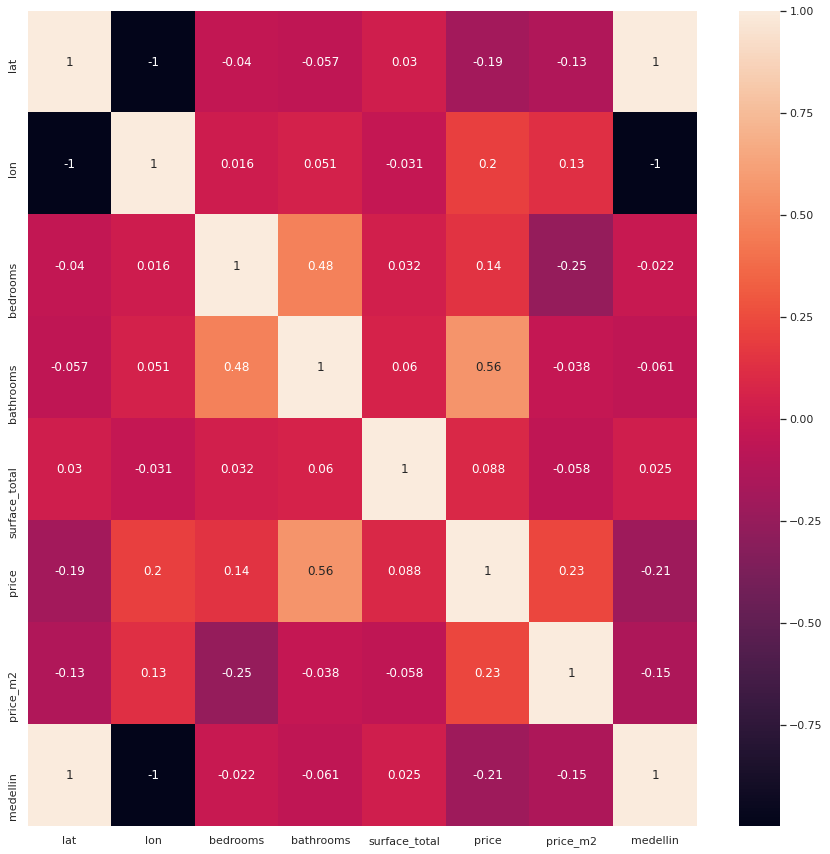

In [191]:
corr = df_medellin.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True)

## Machine Learning - Initial Model

In [192]:
X_df = df_medellin.drop('price', axis=1).copy()
Y_df = df_medellin['price'].copy()

In [193]:
from sklearn.model_selection import train_test_split

In [194]:
X_train_or, X_test_or, Y_train_or, Y_test_or = train_test_split(X_df, Y_df, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [195]:
# Para eliminar SettingWithCopyWarning
X_train = X_train_or.copy()
X_test = X_test_or.copy()
Y_train = Y_train_or.copy()
Y_test = Y_test_or.copy()

In [196]:
from sklearn.preprocessing import (PowerTransformer, StandardScaler, 
                                   MinMaxScaler, LabelEncoder, OneHotEncoder)

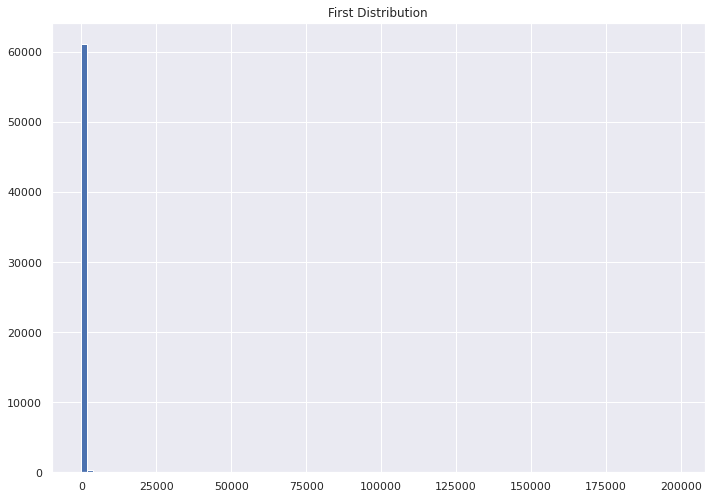

In [197]:
# Validar que todos los valores sean mayores a 0 para poder realizar la transformación.
(X_train["surface_total"]>0).sum() == len(X_train)
X_train["surface_total"].hist(bins=100)
plt.title("First Distribution")
plt.show()

/usr/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecatio

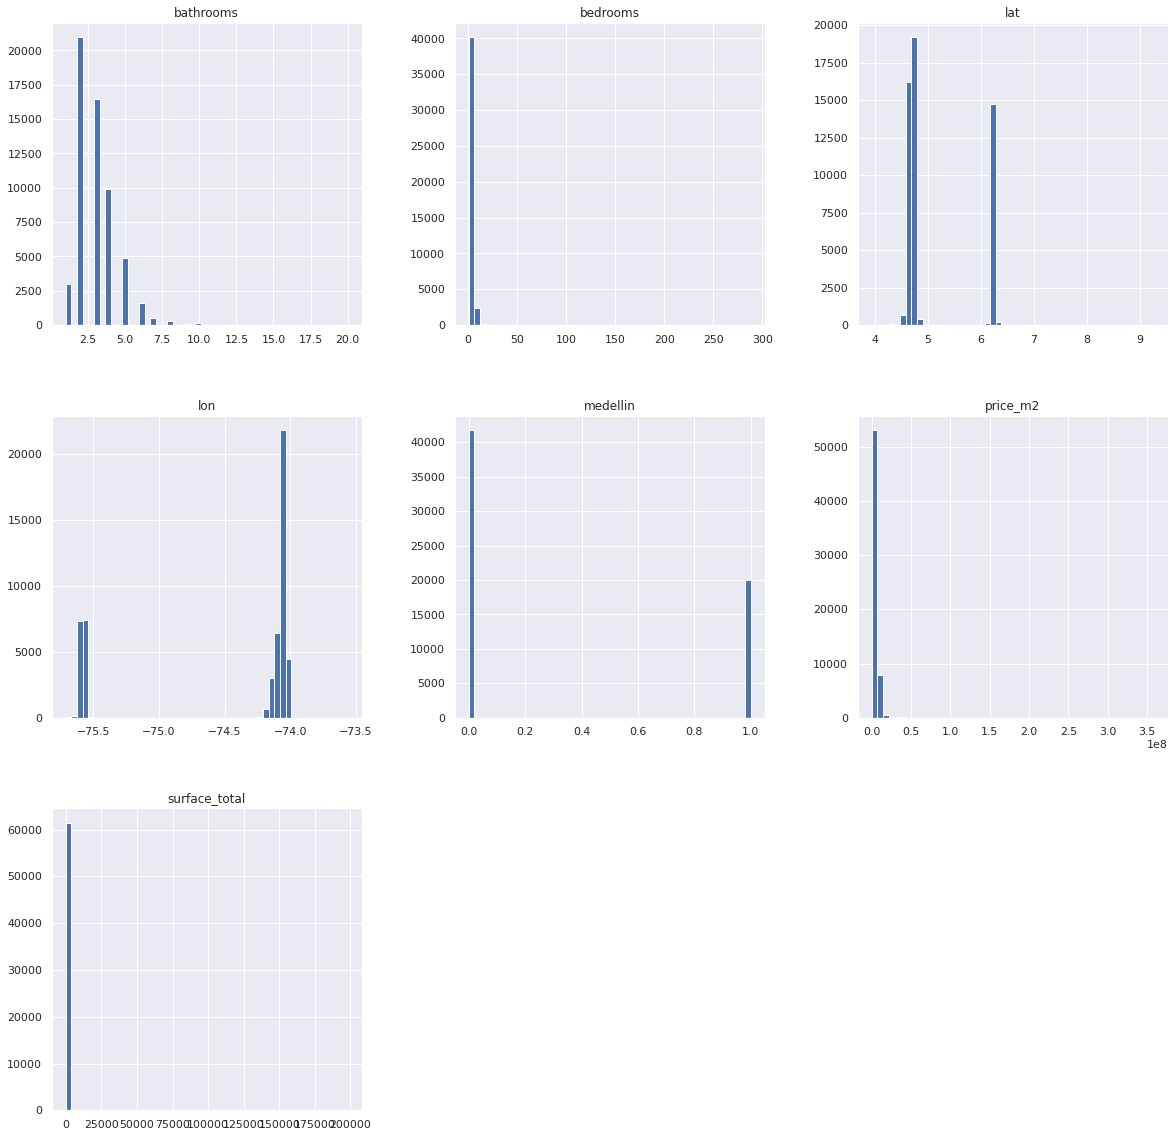

In [198]:
X_train_or.hist(bins=50, figsize=(20,20))
plt.show()

### Power Transformer Labels (Box-Cox)

Normalize and reduce scale

In [199]:
box_cox = PowerTransformer(method='box-cox') # Box-Cox object instance
box_cox.fit(X_train["surface_total"].values.reshape(-1,1)) # Box-Cox, array 2 dimensions
X_train.loc[:,"surface_total"] = box_cox.transform(X_train["surface_total"].values.reshape(-1,1)) # Transformamos el array
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,property_type,price_m2,medellin
884671,NaN,NaN,NaN,NaN,0.475971,Casa,7.812500e+06,0
496647,6.227737,-75.564678,NaN,2.0,-0.833444,Apartamento,3.375000e+06,1
29953,4.673000,-74.049000,NaN,1.0,-2.522814,Casa,8.571429e+06,0
779097,4.708090,-74.030010,3.0,4.0,-0.351051,Otro,6.355140e+06,0
788147,4.725000,-74.037003,2.0,2.0,-0.900764,Otro,4.740260e+06,0


In [200]:
box_cox.lambdas_ # Lambdas aprendidos

array([-0.36728315])

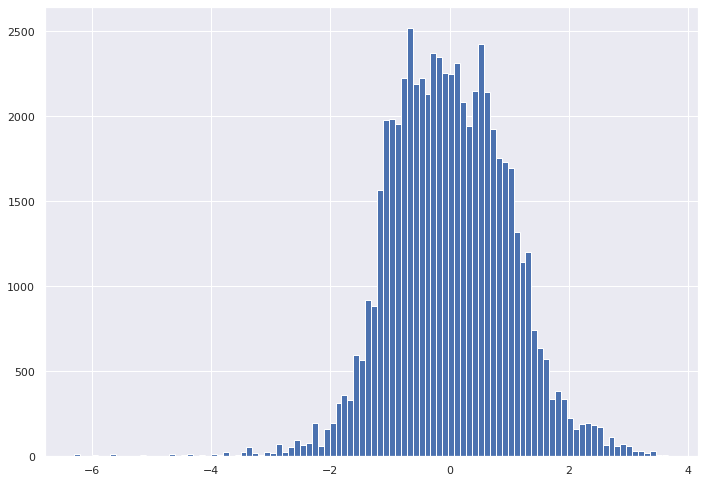

In [201]:
# Visualización de distribución
X_train["surface_total"].hist(bins=100)
plt.show()
# Se aproxima en gran medida a una distribución normal visualmente
# Nótese que los datos están centrados en 0 y pareciera que tiene desviación unitaria.

### Standard Scaler
El Standard Scaler sirve para centrar una distribución en 0 y que tenga desviación estándar unitaria.

 $$\mathbf{Z} = \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}}$$


In [202]:
print("Classes: ", X_train['property_type'].unique()) # Clases categoricas
X_train.head()

Classes:  ['Casa' 'Apartamento' 'Otro' 'Local comercial' 'Oficina' 'Finca' 'Lote'
 'Parqueadero' 'Depósito']


,lat,lon,bedrooms,bathrooms,surface_total,property_type,price_m2,medellin
884671,NaN,NaN,NaN,NaN,0.475971,Casa,7.812500e+06,0
496647,6.227737,-75.564678,NaN,2.0,-0.833444,Apartamento,3.375000e+06,1
29953,4.673000,-74.049000,NaN,1.0,-2.522814,Casa,8.571429e+06,0
779097,4.708090,-74.030010,3.0,4.0,-0.351051,Otro,6.355140e+06,0
788147,4.725000,-74.037003,2.0,2.0,-0.900764,Otro,4.740260e+06,0


In [203]:
le_proper_type = LabelEncoder()
le_proper_type.fit(X_train['property_type'])
X_train['property_type'] = le_proper_type.transform(X_train['property_type'])

In [204]:
ohe_proper_type = OneHotEncoder()
ohe_proper_type.fit(X_train["property_type"].values[:,None])
out = ohe_proper_type.transform(X_train["property_type"].values[:,None]) 
out_array = out.toarray()
ohe_cols_op = []
for category in ohe_proper_type.categories_[0]:
    current_class = le_proper_type.classes_[int(category)]
    col_add = "op_" + current_class
    ohe_cols_op.append(col_add)
    X_train[col_add] = out_array[:,int(category)]

X_train = X_train.drop("property_type", axis =1)

In [205]:
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,price_m2,medellin,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
884671,NaN,NaN,NaN,NaN,0.475971,7.812500e+06,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496647,6.227737,-75.564678,NaN,2.0,-0.833444,3.375000e+06,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29953,4.673000,-74.049000,NaN,1.0,-2.522814,8.571429e+06,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779097,4.708090,-74.030010,3.0,4.0,-0.351051,6.355140e+06,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
788147,4.725000,-74.037003,2.0,2.0,-0.900764,4.740260e+06,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Tratamiento de datos faltantes o NaN

In [206]:
from sklearn.impute import SimpleImputer
# NaNs Columns
X_train.isnull().sum()

lat                   10142
lon                   10142
bedrooms              19119
bathrooms              3713
surface_total             0
price_m2                  0
medellin                  0
op_Apartamento            0
op_Casa                   0
op_Depósito               0
op_Finca                  0
op_Local comercial        0
op_Lote                   0
op_Oficina                0
op_Otro                   0
op_Parqueadero            0
dtype: int64

In [207]:
#Using Simple Imputer

si_bedrooms = SimpleImputer(strategy='median')
si_bedrooms.fit(X_train["bedrooms"].values[:,None])
X_train["bedrooms"] = si_bedrooms.transform(X_train["bedrooms"].values[:,None])

si_lat = SimpleImputer(strategy='median')
si_lat.fit(X_train["lat"].values[:,None])
X_train["lat"] = si_lat.transform(X_train["lat"].values[:,None])

si_lon = SimpleImputer(strategy='median')
si_lon.fit(X_train["lon"].values[:,None])
X_train["lon"] = si_lon.transform(X_train["lon"].values[:,None])

si_bath = SimpleImputer(strategy='median')
si_bath.fit(X_train["bathrooms"].values[:,None])
X_train["bathrooms"] = si_bath.transform(X_train["bathrooms"].values[:,None])

In [208]:
#Otras transformaciones
cols2scale = ['lon', 'lat', 'bedrooms', 'bathrooms', 'price_m2']
se_cols2scale = StandardScaler()
se_cols2scale.fit(X_train[cols2scale])
X_train[cols2scale] = se_cols2scale.transform(X_train[cols2scale])
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,price_m2,medellin,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
884671,-0.536579,0.558853,-0.168349,-0.046701,0.475971,0.541939,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496647,1.752211,-1.730336,-0.168349,-0.781959,-0.833444,-0.333567,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29953,-0.593922,0.603507,-0.168349,-1.517217,-2.522814,0.691673,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779097,-0.540971,0.632748,-0.168349,0.688558,-0.351051,0.254406,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
788147,-0.515453,0.621981,-0.669428,-0.781959,-0.900764,-0.064206,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [209]:
X_test['surface_total'] = box_cox.transform(X_test['surface_total'].values[:,None])


In [210]:
X_test['property_type'] = le_proper_type.transform(X_test['property_type'])

In [211]:
temp_test = ohe_proper_type.transform(X_test["property_type"].values[:,None]).toarray()
for idx, col in enumerate(ohe_cols_op):
    X_test[col] = temp_test[:,idx]

X_test = X_test.drop("property_type", axis=1)

In [212]:
X_test['bedrooms'] = si_bedrooms.transform(X_test["bedrooms"].values[:,None])
X_test['lat'] = si_lat.transform(X_test['lat'].values[:, None])
X_test['lon'] = si_lon.transform(X_test['lon'].values[:, None])
X_test['bathrooms'] = si_bath.transform(X_test['bathrooms'].values[:,None])

In [213]:
X_test[cols2scale] = se_cols2scale.transform(X_test[cols2scale])

In [214]:
assert (X_test.columns.values == X_train.columns.values).all()

In [215]:
X_test

,lat,lon,bedrooms,bathrooms,surface_total,price_m2,medellin,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
338315,-0.737279,0.509578,0.332730,-0.781959,0.742767,-0.727027,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260883,-0.578889,0.604094,-0.168349,-1.517217,-1.153925,0.175503,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
776241,1.737518,-1.790878,-0.168349,-0.046701,-0.833444,-0.358230,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
876559,1.762551,-1.770406,-0.168349,-0.781959,-0.559577,-0.264828,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
923713,-0.602976,0.609666,-0.669428,-0.046701,-0.090006,0.864780,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714877,1.737518,-1.790878,-0.168349,-0.781959,-1.364143,-0.193815,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602381,-0.582417,0.607892,-1.170507,-0.781959,-0.996318,0.054608,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
318666,-0.536579,0.558853,-0.168349,-0.781959,-0.748870,-0.224349,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
597125,1.695558,-1.717472,-0.168349,-0.046701,0.587756,0.127967,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Linear Regression

In [216]:
from sklearn.linear_model import LinearRegression 
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
lin_reg.intercept_, lin_reg.coef_

(20.357791014657728,
 array([ 0.52357866,  0.51569627, -0.06841086,  0.10141299,  0.5630405 ,
         0.28110744, -0.22396225,  0.03202108, -0.14916538,  0.02698088,
        -0.45950414,  0.3420179 , -0.27512   ,  0.31268779,  0.05543134,
         0.11465051]))

In [217]:
Y_test_estimate = lin_reg.predict(X_test)

In [218]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [219]:
rmse = mean_squared_error(Y_test, Y_test_estimate, squared=True)
print("Root Mean Square Error (RMSE)= {:.2f}".format(rmse))

Root Mean Square Error (RMSE)= 0.11


In [220]:
mae = mean_absolute_error(Y_test, Y_test_estimate)
print("Mean Absolute Error (MAE)= {:.2f}".format(mae))

Mean Absolute Error (MAE)= 0.23


In [221]:
r2 = r2_score(Y_test, Y_test_estimate)
print("R_2 = {:.3f}".format(r2))

R_2 = 0.756


### Estimated vs Real

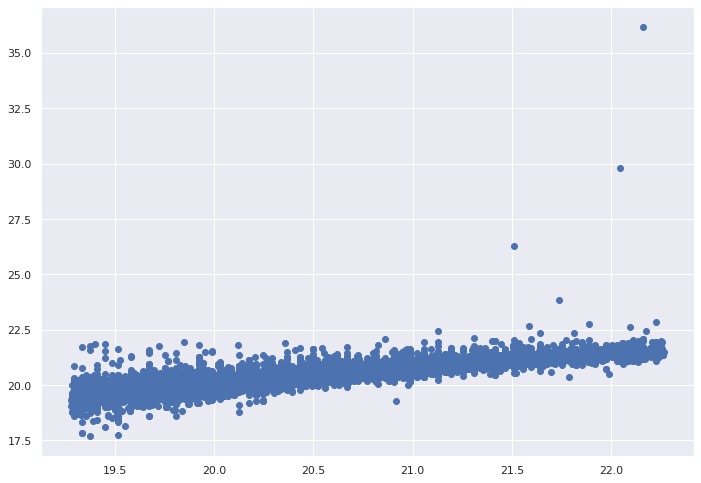

In [222]:
plt.scatter(Y_test, Y_test_estimate)